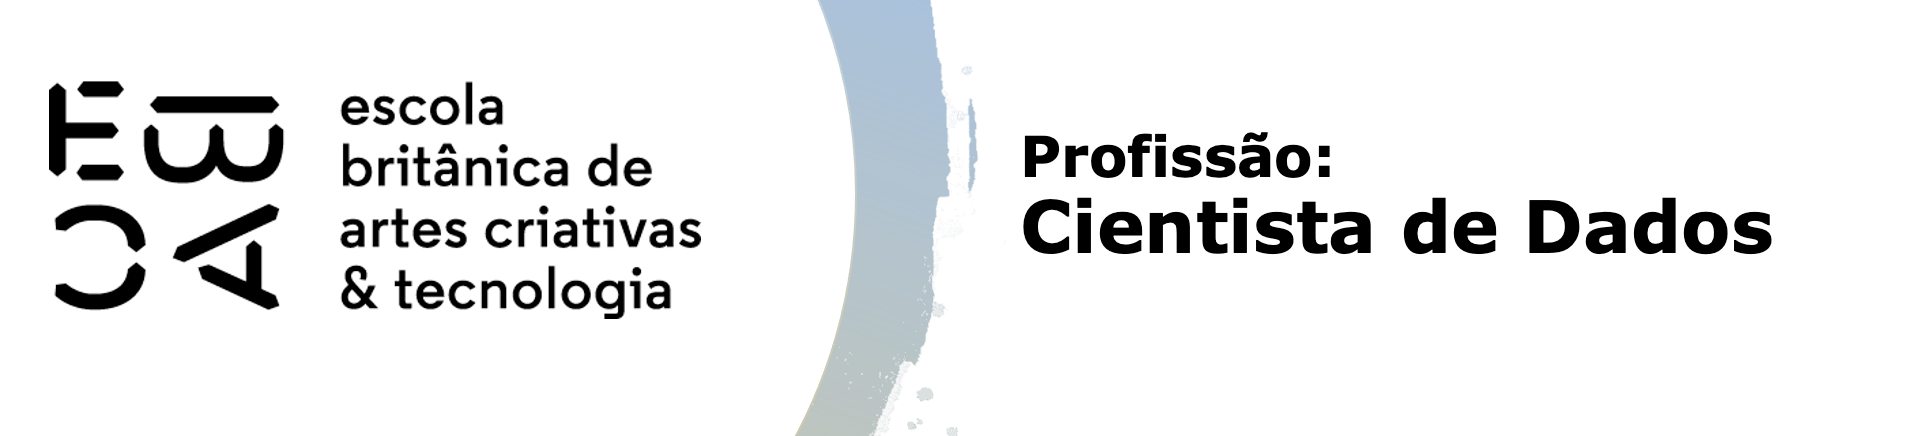

# Análise de *Clusters*

## Aplicação

Nesta demonstração vamos aplicar o K-Means na based de dados de "*Human Activity Recognition using Smartphones*", disponível no [UCI](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) (repositório de bases de dados para *Machine Learning* da Universidade de Irvine.

## Fluxo de projeto

Lembre-se do [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining). Ao discutir o algoritmo estamos nos concentrando em uma parte específica do fluxo de um projeto enorme, mas essa parte depende fortemente do entendimento do negócio.

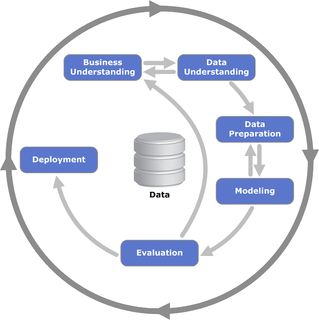

Métodos de agrupamento trazem uma carga subjetiva bem maior que métodos de classificação como árvores de decisão e *random forest*, e o entendimento do negócio tem um papel crucial aqui. Ao decidir que variáveis entram no modelo estamos interferindo fortemente nos resultados, e essa decisão deve depender do objetivo do negócio. Por exemplo, se o objetivo é entender padrões de consumo, tipicamente variáveis biométricas ou financeiras do cliente não devem ser relevantes. Por outro lado, se estamos estudando o desempenho de atletas, talvez a prioridade seja diferente.

**O nosso objetivo** é verificar se encontramos padrões de movimentação que definam bem grupos de observações semelhantes entre si e diferentes entre si, depois vamos tentar interpretar estes grupos.

Para isso vamos fazer uma seleção de variáveis (*feature selection*) com ideias bem simples, porém usando um pouco a criatividade para estarmos conectados aos objetivos iniciais. Esteja sempre conectado ao objetivo inicial!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

%reload_ext watermark
%watermark -iv -v -p sklearn

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

sklearn: 0.0.post11

matplotlib: 3.8.1
seaborn   : 0.13.0
pandas    : 2.1.3



In [2]:
#X_train = pd.read_feather('X_train.ftr')
#y_train = pd.read_feather('y_train.ftr')
#X_test = pd.read_feather('X_test.ftr')
#y_test = pd.read_feather('X_test.ftr')
#labels = pd.read_feather('labels.ftr')
#
#y_train_cat = pd.Categorical.from_codes(codes=(y_train-1).values.flatten(),categories= labels.label)
#y_train_cat.value_counts()

In [3]:
filename_features = "./Dados/UCI HAR Dataset/features.txt"
filename_labels = "./Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "./Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "./Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "./Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "./Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "./Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.nome_var)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.nome_var)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

y_train_cat = pd.Categorical.from_codes(codes=(y_train-1).values.flatten(),categories= labels.label)
y_train_cat.value_counts()

WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
SITTING               1286
STANDING              1374
LAYING                1407
Name: count, dtype: int64

## Tratamento das variáveis

Já vimos que a escala de medida das variáveis pode ter um impacto bastante relevante no resultado de um agrupamento, o que pode ter um efeito arbitrário, sem controle e levar a resultados ruins. Vamos padronizar todas as variáveis para que fiquem com média 0 e variância 1, de modo a mitigar esse efeito.

**OBS:** A saída do ```StandardScaler``` é um array do Numpy. Vamos converter em *Data aFrame* do Pandas.

Vamos aproveitar e colocar o rótulo na base, já transformando no tipo Category do Pandas, que facilita muito o tratamento (além de ganhar eficiencia em termos de armazenamento e velocidade).

In [4]:
X_pad = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)

X_pad['y'] = y_train_cat

## Seleção de variáveis

Lembrando do nosso objetivo: capturar padrões de movimento nas variáveis de variação do acelerômetro e giroscópio do celular, tipificando grupos de variação semelhantes dentro, e diferentes entre grupos.

Tendo isso em mente, a ideia é selecionar variáveis que representem as atividades que as pessoas estão fazendo, uma para cada atividade. Então vamos usar a criatividade (rimou...).

Vamos calcular a média de cada variável dentro de cada um dos grupos. Lembrando que a média geral das variáveis padronizadas é zero, um valor descolado do zero deve indicar que a variável representa aquele comportamento. Então vamos selecionar a variável com o maior valor absoluto da mediana para cada comportamento.

In [5]:
med_por_grupo = X_pad.groupby('y',observed=False).median()
med_por_grupo

,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
y,,,,,,,,,,,,,,,,,,,,,
WALKING,0.001339,-0.004197,-0.022651,0.624258,0.943942,0.783498,0.629471,0.947902,0.778652,0.668609,...,-0.038043,0.548251,0.375385,0.071887,-0.084158,0.018578,-0.019639,-0.537485,0.570071,0.368843
WALKING_UPSTAIRS,-0.111342,-0.129993,-0.079354,0.826692,0.979932,0.979584,0.796929,1.010035,1.036648,0.788137,...,-0.136773,-0.273354,-0.402196,0.096611,0.092363,-1.168191,0.140391,-0.280772,0.786554,0.541494
WALKING_DOWNSTAIRS,0.148981,-0.000460,0.001794,1.667572,1.138867,0.877696,1.655572,1.093075,0.858755,1.739815,...,-0.081643,-0.067258,-0.289348,-0.108722,-0.159323,1.205680,-0.202423,-0.575288,0.485868,0.353224
SITTING,0.040108,0.030341,0.017935,-0.864828,-0.931991,-0.887878,-0.858224,-0.931200,-0.892588,-0.860296,...,0.314368,-0.410291,-0.505962,0.004821,0.026693,0.000788,-0.024322,-0.486927,-0.126636,-0.219827
STANDING,0.042968,0.014663,0.006529,-0.866348,-0.906935,-0.881136,-0.859298,-0.906065,-0.886009,-0.860320,...,0.012261,-0.284633,-0.398046,-0.008891,0.019477,-0.054046,0.048314,-0.589258,0.509357,0.277240
LAYING,0.034988,0.008128,0.018309,-0.840948,-0.929483,-0.900528,-0.834799,-0.930004,-0.906778,-0.842210,...,0.260927,-0.315508,-0.422225,-0.000313,0.042262,0.023174,0.109880,1.951173,-1.773325,-1.585464


Agora vamos selecionar as colunas, pegando para cada linha o nome da coluna com valor máximo.

In [6]:
colunas = med_por_grupo.abs().idxmax(axis=1).values
colunas

array(['349 fBodyAccJerk-std()-Y', '370 fBodyAccJerk-maxInds-X',
       '509 fBodyAccMag-energy()', '78 tGravityAcc-correlation()-X,Y',
       '297 fBodyAcc-skewness()-X', '57 tGravityAcc-energy()-X'],
      dtype=object)

In [7]:
med_por_grupo[colunas]

,349 fBodyAccJerk-std()-Y,370 fBodyAccJerk-maxInds-X,509 fBodyAccMag-energy(),"78 tGravityAcc-correlation()-X,Y",297 fBodyAcc-skewness()-X,57 tGravityAcc-energy()-X
y,,,,,,
WALKING,1.202232,-0.054779,0.173209,0.126327,-0.032826,0.587410
WALKING_UPSTAIRS,0.531527,-1.279263,0.438330,0.656643,0.654751,0.394938
WALKING_DOWNSTAIRS,1.166609,-1.279263,1.887126,0.321926,0.370770,0.544520
SITTING,-0.856693,0.679912,-0.711657,-1.284109,-0.863811,0.523054
STANDING,-0.848196,0.679912,-0.711024,0.742047,-1.052473,0.625828
LAYING,-0.859069,0.435015,-0.711078,0.487033,0.275065,-2.015754


Vamos criar uma lista com o nome de todas as variáveis mais o rótulo da atividade para indicar no gráfico.

In [8]:
colunas2 = list(colunas) + ['y']
colunas2

['349 fBodyAccJerk-std()-Y',
 '370 fBodyAccJerk-maxInds-X',
 '509 fBodyAccMag-energy()',
 '78 tGravityAcc-correlation()-X,Y',
 '297 fBodyAcc-skewness()-X',
 '57 tGravityAcc-energy()-X',
 'y']

In [ ]:
sns.pairplot(X_pad[colunas2], hue='y')

## Aplicando o *k-means*

Vamos rodar a análise de cluster conforme vimos na outra aula, solicitando 6 grupos, e indicando as 6 variáveis que selecionamos.

In [ ]:
cluster = KMeans(n_clusters=6)
cluster.fit_predict(X_pad[colunas])

In [ ]:
cluster.labels_

In [ ]:
X_pad['grupos'] = pd.Categorical(cluster.labels_)
colunas3 = list(colunas) + ['grupos']

## Descrevendo os grupos

Para descrever os grupos podemos utilizar todos os recursos de análise descritiva e visualização de dados que conhecemos. Vamo fazer um ```pairplot``` com opções diferentes de ```hue```, uma tabela cruzada e boxplots. Em um projeto real, tipicamente essa análise se estende tanto quanto necessário, podendo inclusive se ter um *dashboard* interativo da análise. 

In [ ]:
sns.pairplot(X_pad[colunas3], hue='grupos')

In [ ]:
pd.crosstab(X_pad.y, X_pad.grupos)

In [ ]:

def dataviz_grupos(varx):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    sns.boxplot(data=X_pad, y='grupos', x=varx, ax=ax[0])
    sns.boxplot(data=X_pad, y='y', x=varx, ax=ax[1])
    plt.show()

dataviz_grupos(colunas[5])

## Outra seleção de variáveis

O código abaixo tem outra abordagem para a seleção de variáveis: Ele faz, para cada variável, para cada grupo, um *teste-t* (teste de diferença de médias) que testa a significância da diferença da média do grupo contra as demais observações.

A ideia é selecionar variáveis que discriminem melhor cada uma das atividades, e portanto *representem* melhor a atividade.

In [ ]:
from scipy.stats import ttest_ind

ttest_ind(X_pad.loc[X_pad.y.cat.codes == 0,colunas[0]], 
          X_pad.loc[X_pad.y.cat.codes != 0,colunas[0]])

In [ ]:
estatisticas_t = med_por_grupo.copy()
estatisticas_t.loc[:,:] = 0
estatisticas_t

In [ ]:
for var in [estatisticas_t.columns]:
    for grupo in X_pad.y.unique():
        estatisticas_t.loc[grupo, var] = ttest_ind(X_pad.loc[X_pad.y == grupo, var], 
                                                   X_pad.loc[X_pad.y != grupo, var])[0]
 


In [ ]:
estatisticas_t

In [ ]:
colunas_tt = estatisticas_t.abs().idxmax(axis=1).values
colunas_tt

In [ ]:
cluster.fit_predict(X_pad[colunas_tt])
X_pad['grupos2'] = pd.Categorical(cluster.labels_)
colunas4 = list(colunas) + ['grupos2']

In [ ]:
sns.pairplot(X_pad[colunas4], hue='grupos2')

In [ ]:
pd.crosstab(X_pad.y, X_pad.grupos2)

In [ ]:
def dataviz_grupos2(varx):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    sns.boxplot(data=X_pad, y='grupos2', x=varx, ax=ax[0])
    sns.boxplot(data=X_pad, y='y', x=varx, ax=ax[1])
    plt.show()

In [ ]:
dataviz_grupos2(colunas_tt[0])